In [2]:
import os
# os.environ['KAGGLE_CONFIG_DIR'] = r'C:\Users\nicco\OneDrive\Documents\Github\pjts\Misc\Kaggle'
# !kaggle competitions download -c store-sales-time-series-forecasting

In [3]:
# import zipfile
# from io import BytesIO

# file = zipfile.ZipFile(('store-sales-time-series-forecasting.zip'))
# file.namelist()

In [4]:
# file.extractall('store-sales-time-series-forecasting')

In [31]:
import pandas as pd

folder_path = 'store-sales-time-series-forecasting'

holidays_events = pd.read_csv(os.path.join(folder_path, 'holidays_events.csv'))
oil = pd.read_csv(os.path.join(folder_path, 'oil.csv'))
sample_submission = pd.read_csv(os.path.join(folder_path, 'sample_submission.csv'))
stores = pd.read_csv(os.path.join(folder_path, 'stores.csv'))
test = pd.read_csv(os.path.join(folder_path, 'test.csv'))
train = pd.read_csv(os.path.join(folder_path, 'train.csv'))
transactions = pd.read_csv(os.path.join(folder_path, 'transactions.csv'))

print("\nHolidays and Events shape:", holidays_events.shape)
print("Oil data shape:", oil.shape)
print("Sample submission shape:", sample_submission.shape)
print("Stores shape:", stores.shape)
print("Test data shape:", test.shape)
print("Train data shape:", train.shape)
print("Transactions shape:", transactions.shape)


Holidays and Events shape: (350, 6)
Oil data shape: (1218, 2)
Sample submission shape: (28512, 2)
Stores shape: (54, 5)
Test data shape: (28512, 5)
Train data shape: (3000888, 6)
Transactions shape: (83488, 3)


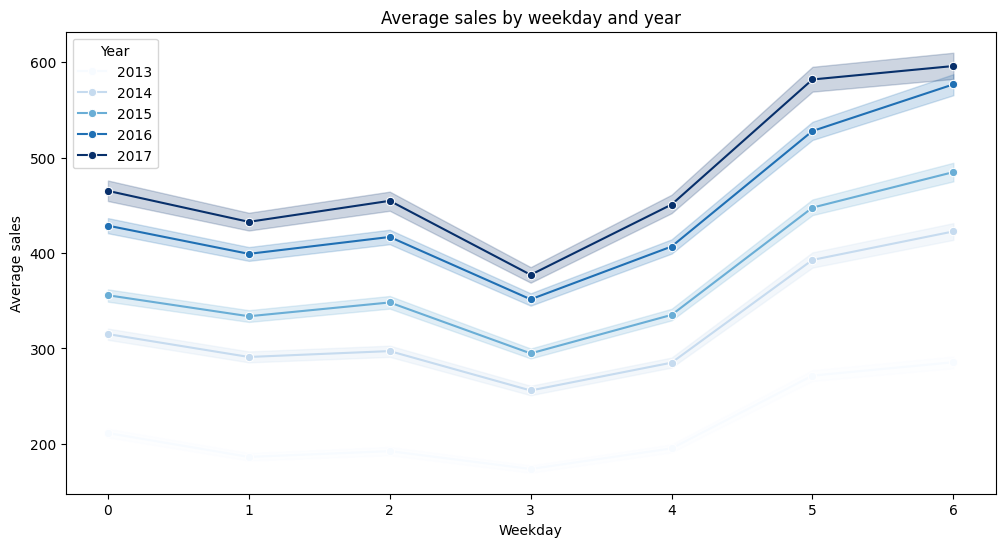

(array([0.00000000e+00, 1.21630664e-04, 2.43261328e-04, ...,
        1.82499757e+02, 1.82499878e+02, 1.82500000e+02]),
 array([2.83618956e-25, 1.13777589e+02, 5.61710117e+01, ...,
        9.32132357e-01, 2.93898960e+00, 3.33585559e+01]),
 <Axes: title={'center': 'Periodogram'}, xlabel='Frequency', ylabel='Variance'>)

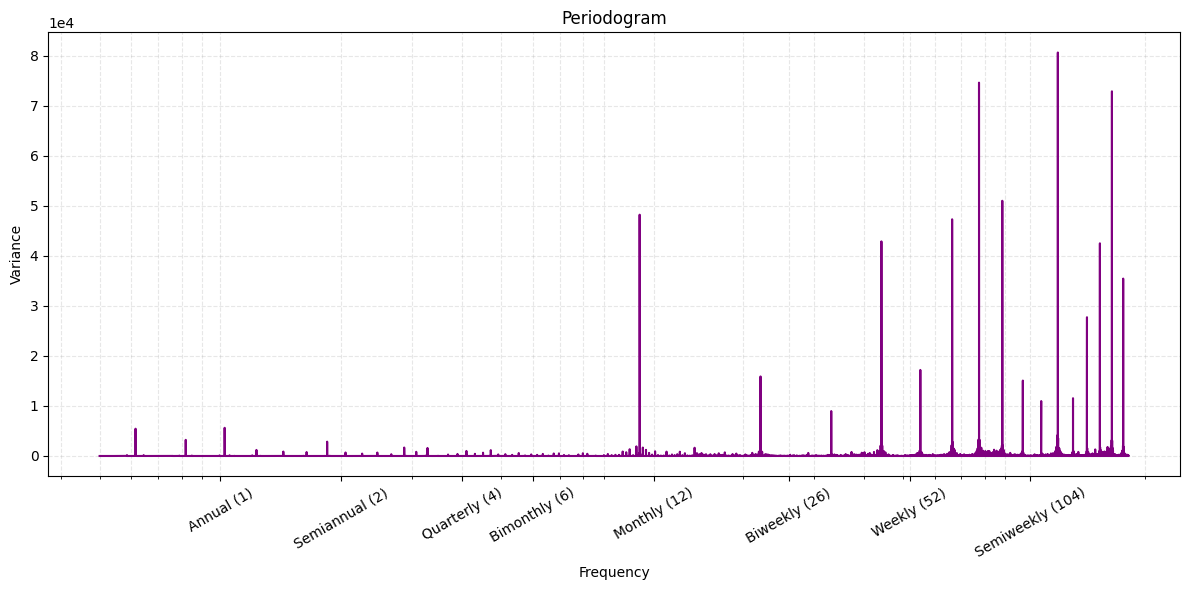

In [32]:
import sys
sys.path.append('C:\\Users\\nicco\\OneDrive\\Documents\\Github\\pjts\\Nikpick')
from beaufunc import seasonality_plot, periodogram_plot

seasonality_plot(train, date_column='date', value_column='sales', freq1='weekday', freq2='year', color_palette='Blues', grid=False, errorbar=True)

periodogram_plot(train['sales'], freq='D', min_freq=0.5, detrend='linear', figsize=(12, 6))

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train['weekday'] = train['date'].dt.weekday
ddummy = pd.get_dummies(train['weekday'], drop_first=True, prefix='weekdayh')
train = pd.concat([train, ddummy], axis=1)
train.drop('weekday', axis=1, inplace=True)
train

,id,date,store_nbr,family,sales,onpromotion,1,2,3,4,5,6
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,True,False,False,False,False,False
1,1,2013-01-01,1,BABY CARE,0.000,0,True,False,False,False,False,False
2,2,2013-01-01,1,BEAUTY,0.000,0,True,False,False,False,False,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,True,False,False,False,False,False
4,4,2013-01-01,1,BOOKS,0.000,0,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,True,False,False,False,False,False
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,True,False,False,False,False,False
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,True,False,False,False,False,False
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,True,False,False,False,False,False


In [ ]:
def periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

: 

In [ ]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

<Axes: xlabel='date'>

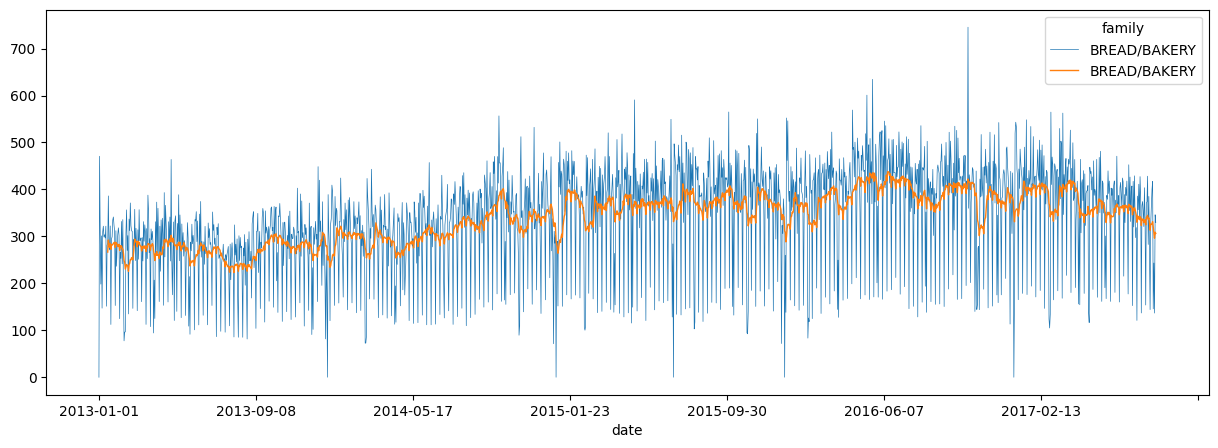

In [ ]:
import numpy as np

ex_data = train[(train['store_nbr'] == 1) & (train['family'] == 'BREAD/BAKERY')].pivot(columns='family', index='date', values='sales')

ax = ex_data.plot(figsize=(15, 5), lw=0.5)

ex_data.rolling(15).mean().plot(ax=ax, lw=1)

In [15]:
from IPython.display import display

display(train[train['store_nbr'] == 1].pivot(columns='family', index='date', values='sales'))
display(test[test['store_nbr'] == 1].pivot(columns='family', index='date', values='onpromotion'))

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,0.000000,0.000,0.0,0.000000
2013-01-02,2.0,0.0,2.0,1091.0,0.0,470.65200,0.0,1060.0,579.0,164.069,...,0.0,369.10100,194.0,0.0,0.0,247.29700,47.000000,0.000,0.0,38.029000
2013-01-03,3.0,0.0,0.0,919.0,0.0,310.65500,0.0,836.0,453.0,151.582,...,0.0,272.31900,153.0,0.0,0.0,187.27800,63.000000,0.000,0.0,17.366001
2013-01-04,3.0,0.0,3.0,953.0,0.0,198.36600,0.0,827.0,460.0,131.411,...,0.0,454.17200,88.0,0.0,0.0,258.02300,67.000000,0.000,0.0,29.907001
2013-01-05,5.0,0.0,3.0,1160.0,0.0,301.05700,0.0,811.0,464.0,118.613,...,0.0,328.94000,141.0,0.0,0.0,212.33301,66.000000,0.000,0.0,24.842000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,0.0,1.0,1006.0,0.0,145.60700,4.0,341.0,343.0,64.302,...,4.0,385.99402,53.0,5.0,3.0,259.11800,24.963001,1115.334,0.0,19.424000
2017-08-12,6.0,0.0,3.0,1659.0,0.0,243.22000,3.0,351.0,526.0,99.488,...,6.0,211.75600,227.0,3.0,6.0,217.66400,48.058000,1762.493,0.0,20.150000
2017-08-13,1.0,0.0,1.0,803.0,0.0,136.67900,1.0,169.0,266.0,47.770,...,4.0,88.18200,45.0,2.0,0.0,115.75800,20.346000,986.669,0.0,11.378000


family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0,0,2,20,0,12,0,25,45,18,...,0,0,18,0,0,0,0,256,14,0
2017-08-17,0,0,1,17,0,7,0,7,13,7,...,0,0,7,0,0,1,0,6,0,0
2017-08-18,0,0,1,12,0,10,0,6,18,52,...,0,48,9,0,1,41,0,5,0,7
2017-08-19,0,0,1,11,0,9,0,11,20,6,...,0,0,9,0,1,0,0,6,0,0
2017-08-20,0,0,1,10,0,5,0,4,17,6,...,0,0,7,0,0,0,0,5,0,0
2017-08-21,0,0,1,14,0,10,0,9,20,7,...,0,0,11,0,1,0,0,3,0,0
2017-08-22,0,0,0,9,0,6,0,10,18,7,...,0,0,9,0,2,1,0,3,0,0
2017-08-23,0,0,1,27,0,14,0,11,22,11,...,0,0,8,0,0,0,0,211,0,0
2017-08-24,0,0,0,26,0,1,0,12,13,11,...,0,0,7,0,0,0,0,3,0,1
